 # 数据导入及预处理


In [11]:
import os

data_dir = 'G:/data'
fname = os.path.join(data_dir, 'd1raw.csv')

f = open(fname, encoding="gb18030")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')    # header of data for each column, shape(1,15) 
lines = lines[1:]    # pure data, shape(420451,1)

print(header)
print(len(lines))
print(len(header))

UnicodeDecodeError: 'gb18030' codec can't decode byte 0xb1 in position 5: illegal multibyte sequence

上面这种方法用open()函数打开excel表格，但无法解码数据，就算使用解码库更大的gb18030也不行，选择忽略部分无法解码的错误时直接集体乱码。因此选择xlrd访问文件并定义函数挨个读取数据如下

In [3]:
import xlrd

def resd_excel():
    wb = xlrd.open_workbook('F:/Coderlife/Pilogue/d1raw.csv')
    sheet = wb.sheet_by_name('1d')
    dat = []
    for a in range(sheet.nrows):
        cells = sheet.row_values(a)
        dat.append(cells)
    return dat
data1 = resd_excel()
data1

[[0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 0.960320106702234, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 1.920640213404468, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 2.880960320106702, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 3.841280426808936, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 4.801600533511171, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 5.761920640213404, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 6.722240746915638, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 7.682560853617872, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 8.642880960320106, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 9.603201067022342, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 10.563521173724574, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 11.523841280426808, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 12.484161387129042, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 13.444481493831276, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 14.40480160053351, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 15.365121707235744, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 16.325441813937978, 0.0, 0.0, 0.0],
 [0.0, 0.0, 50.0, 17.285761920640212, 0.0, 0.0, 0.0],


## 解析数据

In [4]:
import numpy as np

data = np.array(data1)
lines = data.shape[0]
headers = data.shape[1]
print(lines, headers)
float_data = np.zeros((lines, headers))    
for i, line in enumerate(data):
    values = [float(x) for x in data[i]]   
    float_data[i, :] = values
float_data

3000 7


array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## 绘制应力曲线

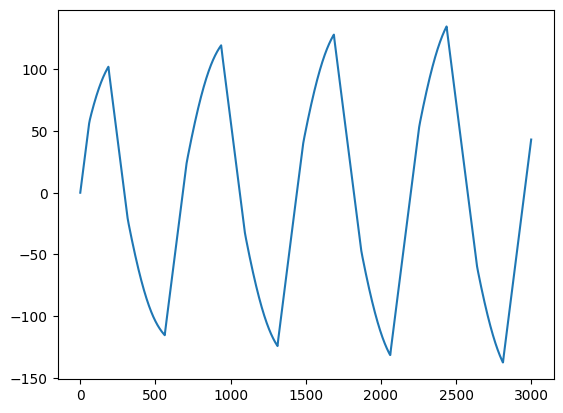

In [5]:
import matplotlib.pyplot as plt

stress = float_data[:, 3]
plt.plot(range(len(stress)), stress)
plt.show()

## 标准化

In [6]:
# 对数据进行标准化，减去特征平均值，再除以标准差
mean = float_data[:1800].mean(axis=0)
float_data -= mean
std = float_data[:1800].std(axis=0)
float_data /= std

# 数据划分

## 生成时间序列样本及其目标的生成器
生成结果为一个元组（samples，targets），其中samples是输入数据的一个批量，targets是对应的目标温度数组，参数介绍—— 
data：浮点数数据组成的原始数组，在上一步中被标准化 
lookback：输入数据应该包括过去多少个时间步 
delay：目标应该在未来多少个时间步之后 
min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步，有助于保存一部分数据用于验证，一部分用于测试 
shuffle：是打乱样本，还是按顺序抽取样本 
batch_size：每个批量的样本数 
step：数据采样的周期（单位：时间步），这里设置为1，为的是每2秒抽取75个数据点，利用上每一个数据点。

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=200, step=1):
    if max_index is None:    # 仅对测试生成器用
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:  # dead cycle
        if shuffle:    # randomly pick up each datapoint
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)    # 重复赋值，该值被r11覆盖
        else:  # pick up in order
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arrange(i, min(i + batch_size, max_index))    # 产生一个数列，等差为1，从i开始，到i + batch_size与max_index中比较小的那个
            i += len(rows)    # 更新i值，一开始为r4给的min_index + lookback，之后每进一次主循环就增加一个batch_size，到max_index封顶
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1] - 3))    # D1: batch_size(不封顶时); D2: timesteps; D3: characters(shape[-1]返回该数组最后一维的长度)
        targets = np.zeros((len(rows), data.shape[-1] - 4))    # D1: 长度为batch_size(不封顶时)，用于装载每个batch的目标温度 
        for j, row in  enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices, :4]
            targets[j] = data[rows[j] + delay][4:]
        yield samples, targets

## 准备训练、验证和测试生成器
generator函数实例化三个生成器：一个用于训练，一个用于验证，一个用于测试。每个生成部分分别读取原始数据的不同时间段：训练器读前2,500个时间步，验证器读取随后的1,500步，测试其读取剩下的时间步。

In [8]:
lookback = 375   # 375为1/2个周期，也就是10s
step = 1
delay = 75    # 75为1/10个周期，也就是2s
batch_size = 32

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1800,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=1801,
                    max_index=2400,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,     # test_gen was not used
                     lookback=lookback,
                     delay=delay,
                     min_index=2401,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_steps = (2500 - 1501 -lookback) // batch_size

test_steps = (len(float_data) - 2501 -lookback) // batch_size

# 模型定义与评估

In [14]:
# 模型定义
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1] - 3)))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(3))
model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])

model.summary()

plot_model(model, to_file='Fatten1d.png', show_shapes=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=103,
                              epochs=100,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1500)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 6004      
                                                                 
 dense_3 (Dense)             (None, 3)                 15        
                                                                 
Total params: 6,019
Trainable params: 6,019
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7412\411738458.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


103/103 [==============================] - 1s 6ms/step - loss: 0.7959 - acc: 0.5212 - val_loss: 0.8430 - val_acc: 0.4720
Epoch 2/100
103/103 [==============================] - 0s 4ms/step - loss: 0.6367 - acc: 0.4078 - val_loss: 0.7197 - val_acc: 0.5066
Epoch 3/100
103/103 [==============================] - 0s 4ms/step - loss: 0.5640 - acc: 0.3981 - val_loss: 0.9659 - val_acc: 0.5033
Epoch 4/100
103/103 [==============================] - 0s 4ms/step - loss: 0.5078 - acc: 0.3935 - val_loss: 0.9829 - val_acc: 0.5066
Epoch 5/100
103/103 [==============================] - 0s 4ms/step - loss: 0.4802 - acc: 0.4163 - val_loss: 0.7594 - val_acc: 0.5049
Epoch 6/100
103/103 [==============================] - 0s 4ms/step - loss: 0.4530 - acc: 0.7321 - val_loss: 1.0070 - val_acc: 0.9243
Epoch 7/100
103/103 [==============================] - 0s 4ms/step - loss: 0.4061 - acc: 0.7688 - val_loss: 0.4474 - val_acc: 0.5477
Epoch 8/100
103/103 [==============================] - 0s 4ms/step - loss: 0.3752

## 评估模型

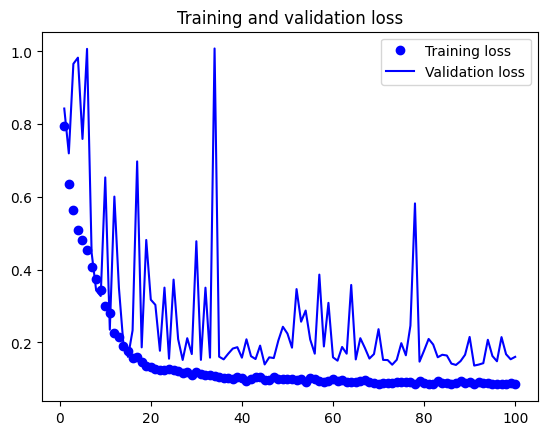

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

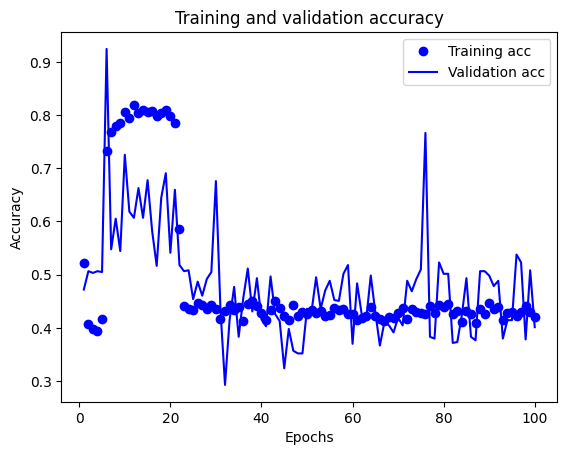

In [16]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 使用模型
这么使用并没有结果。

In [ ]:
model.evaluate(train_gen, batch_size=128)

## 保存模型

In [ ]:
# save the structure and weight
model.save('model1d.h5')

del model

# recover the structure and weight
model = model.load_model('model1d.h5')
model.evaculate(test_gen)

# K折验证
将数据集划分为训练集和验证集。数据少时验证集小，验证分数可能会有很大的波动，数值上表现为验证分数方差很大，这时采用K折交叉验证把数据划分为K个分区，实例化K-1个相同模型，将每个模型在K-1个分区上训练，并在剩下一个分区上评估。最终的模型验证分数取K个验证分数的平均值

## 单独划分数据集
因为上面的模型精度有些不自然，考虑到可能是数据量太小的问题，这里采用K折验证处理模型，因此不用generator函数划分数据集，而单独采用sklearn的train_test_split模块，注意，这里使用的数据应当已经标准化。

In [28]:
# from sklearn import datasets    # 这是个导入sklearn自建数据库的代码，此处没用
from sklearn.model_selection import train_test_split

# 划分数据
X = float_data[:, :4]
Y = float_data[:, 4:]

# 将原始数据划分为训练集和测试集
train_data, test_data, train_targets, test_targets = train_test_split(X, Y, train_size=0.8, random_state=6)    # 注意，该函数有一个默认参数shuffle，值为true，意味着取数据集时是默认打乱了来取的
x_train.shape, x_test.shape

((2400, 4), (600, 4))

## 模型定义

In [ ]:
# 模型定义
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

## K折验证

In [30]:
# K折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
all_scores

[0.5481587052345276,
 0.5744194388389587,
 0.5757656097412109,
 0.5452992916107178]

In [32]:
np.mean(all_scores)

0.5609107613563538

## 增大epoch观察模型表现
前面的4折验证中，验证分数差异已经不大，分布在0.54到0.58之间，平均分数0.56意味着预测应力和实际应力相差！！！不对啊！结果不是一个。。

In [ ]:
from keras import models
from keras import layers
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 绘制验证分数

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 重绘验证分数
①删除前10个数据点，因为这些点取值与其他点不同 ②将每个数据点替换为前面数据点的指数移动平均值。 可以观察到MAE在80轮以后就不再降低，之后开始过拟合

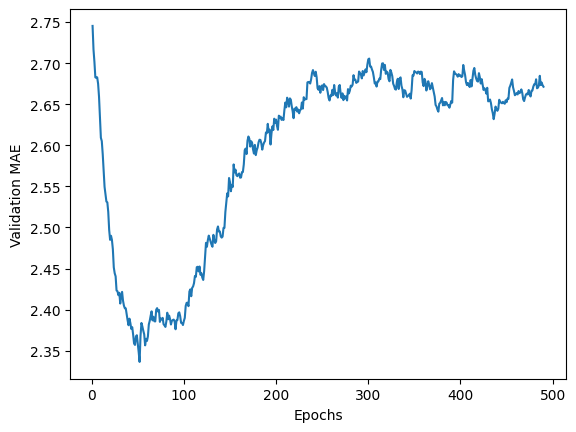

In [13]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 训练最终模型

In [14]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 0s/step - loss: 19.2587 - mae: 2.5964


In [15]:
# 最终结果如下
test_mae_score

2.596359968185425